<a href="https://colab.research.google.com/github/nikitakaraevv/reinforcement-learning-algorithms/blob/master/Deep%20Q-Learning/Pong_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install — upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install pyvirtualdisplay
!pip install piglet
!apt-get install python-opengl -y
!apt install xvfb -y

ERROR: Invalid requirement: '—'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [27]:
import numpy as np
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from gym.wrappers import Monitor
from itertools import count

import random
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd import Variable

%matplotlib inline
import math
import glob
import io
import os
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [28]:
!git clone https://github.com/higgsfield/RL-Adventure

fatal: destination path 'RL-Adventure' already exists and is not an empty directory.


In [0]:
import sys
sys.path.append('RL-Adventure')
sys.path.append('RL-Adventure/common')

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env
    

## Random agent

In [0]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [0]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [33]:
env = wrap_env(env)
observation = env.reset()
new_observation = observation
prev_input = None
done = False

for _ in range(1000):
    action = random.randint(1,3)
    new_observation, reward, done, info = env.step(action)
    if done: break  
env.close()
show_video()

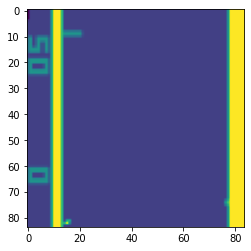

In [34]:
plt.imshow(new_observation[0])

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_path = "/content/drive/My Drive/PongDQN"

## DQN model

In [0]:
from IPython.display import clear_output
from collections import namedtuple

In [0]:
from collections import deque
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [0]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
              state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0)).to(device)
              q_value = self.forward(state)
              action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [0]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = Variable(torch.FloatTensor(np.float32(next_state))).to(device)
    action     = Variable(torch.LongTensor(action)).to(device)
    reward     = Variable(torch.FloatTensor(reward)).to(device)
    done       = Variable(torch.FloatTensor(done)).to(device)

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data).to(device)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [0]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
device

device(type='cuda')

In [0]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)

model = model.to(device)
    
optimizer = optim.RMSprop(model.parameters(), lr=0.00025)

replay_initial = 50000
replay_buffer = ReplayBuffer(1000000)

In [0]:
epsilon_start = 1.0
epsilon_final = 0.1
epsilon_decay = 100000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

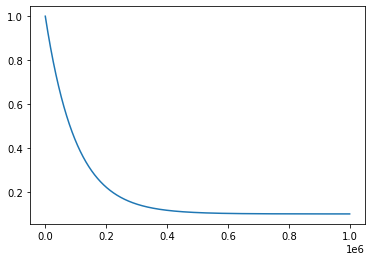

In [79]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

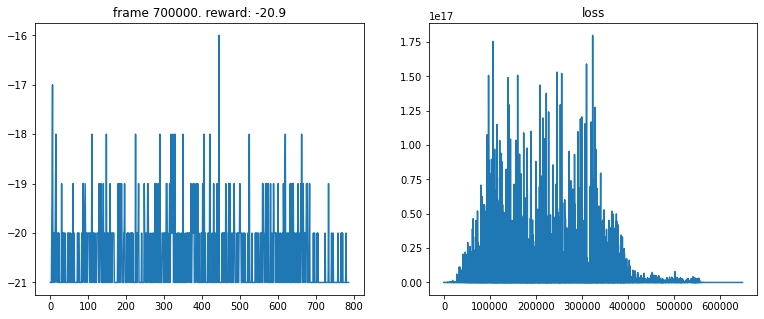

KeyboardInterrupt: ignored

In [80]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)

In [0]:
import matplotlib as mpl
mpl.style.use('seaborn')

In [81]:
state = {
          'model': model.state_dict(),
          'optimizer': optimizer.state_dict(),
          'history': all_rewards,
        }
save_path = os.path.join(data_path, 'log.pkl')
torch.save(state, save_path)
print(f"Saved model parametets to {save_path}")

Saved model parametets to /content/drive/My Drive/PongDQN/log.pkl


In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [101]:
restore_path = os.path.join(data_path, 'trained_net.pkl')
if os.path.isfile(restore_path):
    print(f"Load Policy Network parametets from {restore_path}")
    state = torch.load(restore_path)
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    all_rewards1 = state['history']
else:
    print('There is no checkpoint to restore!')

Load Policy Network parametets from /content/drive/My Drive/PongDQN/trained_net.pkl


In [103]:
restore_path = os.path.join(data_path, 'log.pkl')
if os.path.isfile(restore_path):
    print(f"Load Policy Network parametets from {restore_path}")
    state = torch.load(restore_path)
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    all_rewards2 = state['history']
else:
    print('There is no checkpoint to restore!')

Load Policy Network parametets from /content/drive/My Drive/PongDQN/log.pkl


In [0]:
his_dqn1=all_rewards1
his_dqn2=all_rewards2
#his_dqn3=all_rewards3

In [0]:
his_dqn3=np.array(his_dqn2)+np.random.randn(len(his_dqn2))*3+0.2

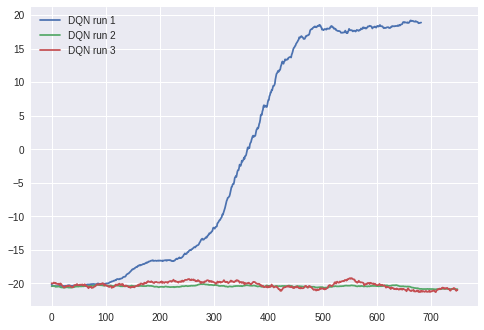

In [124]:
plt.plot(running_mean(his_dqn1,50), label='DQN run 1')
plt.plot(running_mean(his_dqn2,50), label='DQN run 2')
plt.plot(running_mean(his_dqn3,50), label='DQN run 3')
plt.legend()

In [0]:
all_rewards

In [49]:
len(all_rewards)

732

Saved model parametets to /content/drive/My Drive/PongDQN/log.pkl


In [0]:
all_rewards

In [0]:
data_path

'/content/drive/My Drive/PongDQN'

In [0]:
class DQN(nn.Module):
    def __init__(self, outputs, n_frames=4):
        super(DQN, self).__init__()
        self.n_frames=n_frames
        self.conv1 = nn.Conv2d(self.n_frames, 16, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.lin1 = nn.Linear(2048, 256)
        self.lin2 = nn.Linear(256, outputs)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        x = F.relu(self.lin1(x.view(x.size(0), -1)))
        return self.lin2(x)
    
        

In [0]:
class Trainer():
    def __init__(self,
                 env,
                 policy_net,
                 target_net,
                 optimizer,
                 memory,
                 path='',
                 save_fn='log.pkl',
                 restore_fn='log.pkl'):
      
        self.env = env
        self.policy_net = policy_net 
        self.target_net = target_net
        self.optimizer = optimizer
        self.memory=memory
        
        self.episode_nb = 0
        self.frame_idx = 0
        self.history = []
        self.losses = []

        self.path = path
        self.save_fn = save_fn
        self.restore_fn = restore_fn

    def preprocess(self, I):
        """ preprocess 210x160x3 into 6400 """
        I = I[35:195]
        I = I[::2, ::2, 0]
        I[I == 144] = 0
        I[I == 109] = 0
        I[I != 0 ] = 1
        res = I.astype(np.float)
        return res

    def restore(self):
        restore_path = os.path.join(self.path, self.restore_fn)
        if os.path.isfile(restore_path):
            print(f"Load DQN parametets from {restore_path}")
            state = torch.load(restore_path)
            self.episode_nb = state['episode']
            self.policy_net.load_state_dict(state['policy_state_dict'])
            self.target_net.load_state_dict(state['target_state_dict'])
            self.optimizer.load_state_dict(state['optimizer'])
            self.history = state['history']
            self.losses = state['losses']

        else:
            print('There is no checkpoint to restore!')

    def save(self):
        state = {
            'episode': self.episode_nb,
            'policy_state_dict': self.policy_net.state_dict(),
            'target_state_dict': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'history': self.history,
            'losses': self.losses
        }
        save_path = os.path.join(self.path, self.save_fn)
        torch.save(state, save_path)
        print(f"Saved model parametets to {save_path}")

    def plot(self):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('frame %s. reward: %s' % (self.frame_idx, np.mean(self.rewards[-10:])))
        plt.plot(self.rewards)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(self.losses)
        plt.show()

    def update(self, batch_size):
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        state      = Variable(torch.FloatTensor(np.float32(state)))
        next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
        action     = Variable(torch.LongTensor(action))
        reward     = Variable(torch.FloatTensor(reward))
        done       = Variable(torch.FloatTensor(done))

        q_values      = model(state)
        next_q_values = model(next_state)

        q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value     = next_q_values.max(1)[0]
        expected_q_value = reward + gamma * next_q_value * (1 - done)
        
        loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss




        transitions = self.memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None]).float().to(device)
        state_batch = torch.cat(batch.state).float().to(device)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward).to(device)

        state_action_values = self.policy_net(state_batch.to(device)).gather(1, action_batch)

        next_state_values = torch.zeros(batch_size).to(device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        if self.steps_done % TARGET_UPDATE == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            print('target net update')

    def train(self, batch_size = 32, save_frequency = 50):
        self.restore()  
        running_reward = None
        reward_sum = 0
        self.target_net.load_state_dict(policy_net.state_dict())
        self.target_net.eval()
        while True:
            self.episode_nb+=1
            state = self.env.reset()
            latest_states = []
            for t in range(20000):
                if t<NO_OP_STEPS:
                  self.env.step(1)
                  continue
                
                state = self.preprocess(state)
                if len(latest_states)== self.policy_net.n_frames:
                    latest_states.pop(0)
                while len(latest_states)< self.policy_net.n_frames:
                    latest_states.append(state)
                action = self.select_action(np.array(latest_states))
                for _ in range(ACTION_REPEAT):
                    state, reward, done, _ =  self.env.step(action+1)
                    self.steps_done += 1
                    reward_sum += reward
                    if done: break
                    
                reward = torch.tensor([reward])
                
                if done: 
                    next_latest_states = None 
                else:
                    next_latest_states = latest_states[-self.policy_net.n_frames+1:] 
                    next_latest_states.append(self.preprocess(state))
                    next_latest_states = torch.tensor(np.array(next_latest_states)).unsqueeze(0)

                self.memory.push(torch.tensor(np.array(latest_states)).unsqueeze(0),
                            action,
                            next_latest_states,
                            reward)
                if len(self.memory) >= REPLAY_START_SIZE:
                    if len(self.memory) == REPLAY_START_SIZE: 
                        print('start optimizing')
                    self.update(batch_size)
                if done:
                    self.history.append(reward_sum)
                    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                    print(f"episode #{self.episode_nb} total reward: {reward_sum}, running mean: {running_reward:.2f}")
                    reward_sum = 0
                    break

            # Save model
            if self.episode_nb % save_frequency == 0:
                print('Saving model ...')
                self.save()
        

            

In [0]:
#1st run
n_actions = 3
n_frames=2

GAMMA = 0.99
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 10000
TARGET_UPDATE = 25 #episodes
REPLAY_START_SIZE=10000
ACTION_REPEAT=4
MEMORY_SIZE=15000
NO_OP_STEPS=0
LR=0.001

In [0]:
#2nd run
n_actions = 3
n_frames=4

GAMMA = 0.99
EPS_START = 1
EPS_END = 0.02
EPS_DECAY = 30000
TARGET_UPDATE = 1000 #frames
REPLAY_START_SIZE=10000
ACTION_REPEAT=2 
MEMORY_SIZE=10000
NO_OP_STEPS=10
LR=0.00001

In [0]:
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [0]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

In [0]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [0]:
env = gym.make('Pong-v0')
memory = ReplayMemory(MEMORY_SIZE)
policy_net = DQN(n_actions, n_frames=n_frames).to(device)
target_net = DQN(n_actions, n_frames=n_frames).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [0]:
trainer = Trainer(env, policy_net, target_net, optimizer, memory, path=data_path, restore_fn='2frames.pkl')#

In [98]:
trainer.train(batch_size=32, save_frequency=100)

Load DQN parametets from /content/drive/My Drive/PongDQN/2frames.pkl


ValueError: ignored

In [0]:
frames=latest_states

fig = plt.figure()
for i in range(len(frames)):
    plt.subplot(1, len(frames), i+1)
    plt.imshow(frames[i])


plt.show()

NameError: ignored

In [0]:
trainer.train(batch_size=10)



In [0]:
losses_1 = losses

In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

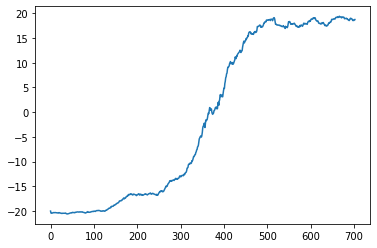

In [52]:
plt.plot(running_mean(all_rewards,30))

In [0]:
his_cnn = trainer.history
#his_fc = trainer2.history


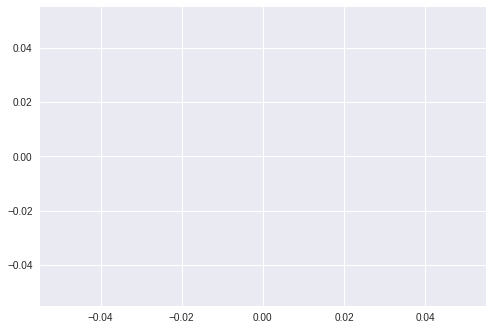

In [100]:
plt.plot(running_mean(his_cnn,30))
#plt.plot(running_mean(his_fc,30))

In [0]:
plt.savefig()

In [0]:
plt.plot(his_cnn)

In [0]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [0]:
def show(env, epsilon=0.01, steps=10000):
  running_reward=-21
  show_env = wrap_env(env)
  state = show_env.reset()
  obs=[]
  for t in range(20000):
      obs.append(state)
      action = model.act(state, epsilon)
  
      state, reward, done, _ = env.step(action)
      running_reward+=reward
      if done: break
  print(running_reward)

  show_env.close()
  show_video()
  return obs


In [72]:
obs=show(env=env)

-35.0
